# Analisis Sentimen pada Aplikasi Shopee

## 1. Import Library dan Import Data

In [ ]:
import pandas as pd  # Pandas untuk manipulasi dan analisis data
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining
import numpy as np  # NumPy untuk komputasi numerik
seed = 0
np.random.seed(seed)  # Mengatur seed untuk reproduktibilitas
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
from sklearn.metrics import accuracy_score

import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
import unicodedata # Modul untuk bekerja dengan Unicode
from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks
from tqdm import tqdm
tqdm.pandas()

import nltk  # Import pustaka NLTK (Natural Language Toolkit).
from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.stem import WordNetLemmatizer # Lemmatization text
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.
nltk.download('punkt_tab') # Download the punkt_tab data package
pd.options.mode.copy_on_write = True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\khair\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khair\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\khair\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [3]:
app_reviews_df = pd.read_csv('app_reviews.csv')

## 2. Dataset Overview

In [4]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              3000 non-null   object
 1   userName              3000 non-null   object
 2   userImage             3000 non-null   object
 3   content               3000 non-null   object
 4   score                 3000 non-null   int64 
 5   thumbsUpCount         3000 non-null   int64 
 6   reviewCreatedVersion  2557 non-null   object
 7   at                    3000 non-null   object
 8   replyContent          1995 non-null   object
 9   repliedAt             1995 non-null   object
 10  appVersion            2557 non-null   object
dtypes: int64(2), object(9)
memory usage: 257.9+ KB


In [5]:
df = app_reviews_df[['content','score']]

In [6]:
# Mengecek data yang kosong atau hilang
df.isnull().sum()

content    0
score      0
dtype: int64

In [7]:
# Menghapus baris yang memiliki duplikat
df.drop_duplicates(inplace=True)

## 3. Text Preprocessing

In [8]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def remove_superscripts_and_subscripts(text):
    # memfilter karakter yang bukan superscript atau subscript
    def is_not_super_or_sub(char):
        # Cek kategori Unicode karakter
        return not (unicodedata.name(char, "").startswith("SUPERSCRIPT") or
                    unicodedata.name(char, "").startswith("SUBSCRIPT"))

    # Filter karakter dari teks
    text = ''.join(filter(is_not_super_or_sub, text))
    return text

def casefoldingText(text): 
    # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): 
    # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): 
    # Menghapus stopwords dalam teks
    filtered = []
    for txt in text:
        if txt not in set(stopwords.words('english')):
            filtered.append(txt)
    text = filtered      
    return text

def lemmatizeText(text): 
    # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    
    # Membuat objek lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Menerapkan stemming pada setiap kata dalam daftar
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]

    return lemmatized_words

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(list_words)
    return sentence

In [9]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['content'].apply(cleaningText).apply(remove_superscripts_and_subscripts)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_casefoldingText'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Mengubah kata-kata dalam teks menjadi bentuk dasarnya
df['text_lemmatize'] = df['text_stopword'].apply(lemmatizeText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_lemmatize'].apply(toSentence)

In [10]:
df.head()

,content,score,text_clean,text_casefoldingText,text_tokenizingText,text_stopword,text_lemmatize,text_akhir
0,Super laggy (I can click stuff on 20GB+ sized ...,1,Super laggy I can click stuff on GB sized apps...,super laggy i can click stuff on gb sized apps...,"[super, laggy, i, can, click, stuff, on, gb, s...","[super, laggy, click, stuff, gb, sized, apps, ...","[super, laggy, click, stuff, gb, sized, apps, ...",super laggy click stuff gb sized apps way easi...
1,"Dear Shopee, I know live shopping is quite a t...",3,Dear Shopee I know live shopping is quite a tr...,dear shopee i know live shopping is quite a tr...,"[dear, shopee, i, know, live, shopping, is, qu...","[dear, shopee, know, live, shopping, quite, tr...","[dear, shopee, know, live, shopping, quite, tr...",dear shopee know live shopping quite trend rig...
2,The app has a persistent bug where I cannot vi...,3,The app has a persistent bug where I cannot vi...,the app has a persistent bug where i cannot vi...,"[the, app, has, a, persistent, bug, where, i, ...","[app, persistent, bug, view, price, list, sort...","[app, persistent, bug, view, price, list, sort...",app persistent bug view price list sorted low ...
3,everytime i open this app it crash and reopen ...,1,everytime i open this app it crash and reopen ...,everytime i open this app it crash and reopen ...,"[everytime, i, open, this, app, it, crash, and...","[everytime, open, app, crash, reopen, keep, en...","[everytime, open, app, crash, reopen, keep, en...",everytime open app crash reopen keep endless t...
4,"So far, it's one pleasant experience. Quite in...",5,So far its one pleasant experience Quite innov...,so far its one pleasant experience quite innov...,"[so, far, its, one, pleasant, experience, quit...","[far, one, pleasant, experience, quite, innova...","[far, one, pleasant, experience, quite, innova...",far one pleasant experience quite innovative s...


## 4. Labeling Kata

In [11]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = "siebert/sentiment-roberta-large-english"

clf = AutoModelForSequenceClassification.from_pretrained(model)
tokenizer = AutoTokenizer.from_pretrained(model)

sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0)

In [12]:
result = sentiment_analysis("I like this product!")
print(result[0]['label'])

c:\Users\khair\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


POSITIVE


In [13]:
def labeling(text):
    result = sentiment_analysis(text)
    return result[0]['label']

In [14]:
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Rows"):
    if pd.isna(row.get("polarity")):  # Skip jika sudah ada nilai
        try:
            df.at[idx, "polarity"] = labeling(row["text_akhir"])
        except Exception as e:
            print(e)
            raise e

Processing Rows: 100%|██████████| 2998/2998 [27:31<00:00,  1.82it/s]


### 4.3 Visualisasi Analisis Sentimen

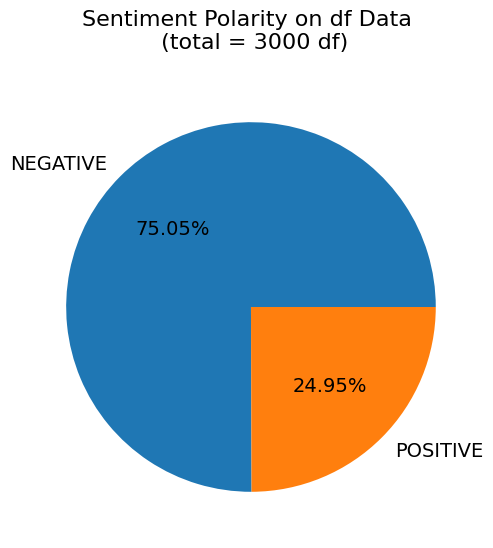

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in df["polarity"].value_counts()]
labels = list(df["polarity"].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(
    x=sizes,
    labels=labels,
    autopct="%1.2f%%",
    textprops={"fontsize": 14},
)
ax.set_title("Sentiment Polarity on df Data \n (total = 3000 df)", fontsize=16, pad=20)
plt.show()

In [17]:
positive_reviews = df[['text_akhir','polarity']].loc[df['polarity'] == 'POSITIVE']
negative_reviews = df[['text_akhir','polarity']].loc[df['polarity'] == 'NEGATIVE']

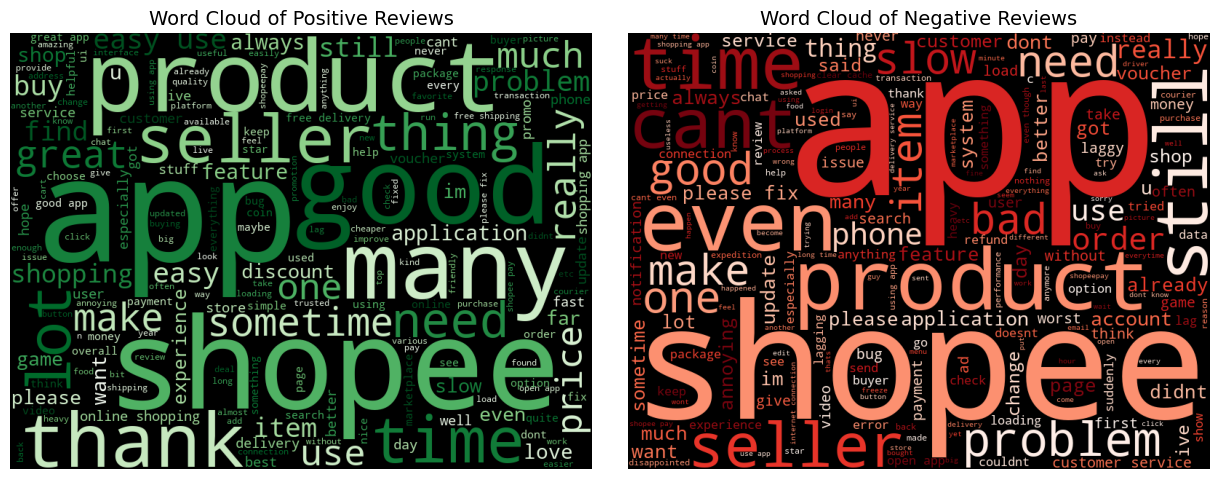

In [18]:
# Visualisasi Word Cloud
fig, ax = plt.subplots(1, 2, figsize=(12, 10))

# Word Cloud pada review positif
list_postive_reviews = ""
for row_word in positive_reviews.iloc[:, 0]:
    list_postive_reviews += " " + (row_word)
wordcloud_positive = WordCloud(
    width=800, height=600, background_color="black", colormap="Greens", min_font_size=10
).generate(list_postive_reviews)
ax[0].set_title(
    "Word Cloud of Positive Reviews",
    fontsize=14,
)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis("off")

# Word Cloud pada review negatif
list_negative_reviews = ""
for row_word in negative_reviews.iloc[:, 0]:
    list_negative_reviews += " " + (row_word)
wordcloud_negative = WordCloud(
    width=800, height=600, background_color="black", colormap="Reds", min_font_size=10
).generate(list_negative_reviews)
ax[1].set_title(
    "Word Cloud of Negative Reviews",
    fontsize=14,
)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis("off")

plt.show()

## 5. Ekstraksi Fitur

### 5.1 TF-IDF

In [65]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = df['text_akhir']
y = df['polarity']
y = y.apply(lambda x: 1 if x=='POSITIVE' else 0)

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(
    ngram_range=(1,2), stop_words='english', 
    max_features=2000, sublinear_tf=True, 
    min_df=3, binary=True
)
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi dataframe
tfidf_features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [109]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=seed)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

In [110]:
X_resampled.shape, y_resampled.shape

((4500, 2000), (4500,))

In [111]:
# Bagi data menjadi data latih dan data uji
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

## 6. Pengembangan Model

### 6.1 Model Naive Bayes

In [112]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

# Membuat objek model Naive Bayes 
nb = BernoulliNB()


# Melatih model Naive Bayes pada data pelatihan
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0]}
grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

# Get Best Model
best_nb = grid_search.best_estimator_

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_nb = best_nb.predict(X_train_tfidf.toarray())
y_pred_test_nb = best_nb.predict(X_test_tfidf.toarray())

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train)
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test)

# Menampilkan akurasi
print('Metode Ekstraksi Fitur: TF-IDF')
print(f'Naive Bayes - accuracy_train \t: {accuracy_train_nb*100:.4f}%')
print(f'Naive Bayes - accuracy_test \t: {accuracy_test_nb*100:.4f}%')

Metode Ekstraksi Fitur: TF-IDF
Naive Bayes - accuracy_train 	: 92.6667%
Naive Bayes - accuracy_test 	: 90.6667%


### 6.2 Model Random Forest

In [113]:
from sklearn.ensemble import RandomForestClassifier

# Membuat objek model Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train_tfidf.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train_tfidf.toarray())
y_pred_test_rf = random_forest.predict(X_test_tfidf.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

# Menampilkan akurasi
print('Metode Ekstraksi Fitur: TF-IDF')
print(f'Random Forest - accuracy_train \t: {accuracy_train_rf*100:.4f}%')
print(f'Random Forest - accuracy_test \t: {accuracy_test_rf*100:.4f}%')

Metode Ekstraksi Fitur: TF-IDF
Random Forest - accuracy_train 	: 100.0000%
Random Forest - accuracy_test 	: 92.1111%


### 6.3 Model Support Vector Machine

In [114]:
from sklearn.svm import SVC

# Membuat objek model SVM
svc = SVC(C=1.1, kernel='sigmoid', random_state=42)

# Melatih model SVM pada data pelatihan
svc.fit(X_train_tfidf.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svc = random_forest.predict(X_train_tfidf.toarray())
y_pred_test_svc = random_forest.predict(X_test_tfidf.toarray())

# Evaluasi akurasi model SVM
accuracy_train_svc = accuracy_score(y_pred_train_svc, y_train)
accuracy_test_svc = accuracy_score(y_pred_test_svc, y_test)

# Menampilkan akurasi
print('Metode Ekstraksi Fitur: TF-IDF')
print(f'SVM - accuracy_train \t: {accuracy_train_svc*100:.4f}%')
print(f'SVM - accuracy_test \t: {accuracy_test_svc*100:.4f}%')

Metode Ekstraksi Fitur: TF-IDF
SVM - accuracy_train 	: 100.0000%
SVM - accuracy_test 	: 92.1111%


### 6.4 Model ANN

In [115]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [116]:
tf.keras.backend.clear_session()

In [117]:
# Define the neural network model
model = Sequential()
model.add(Dense(256, input_shape=(X_train_tfidf.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

c:\Users\khair\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [118]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       512,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,281 (2.08 MB)

 Trainable params: 545,281 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [120]:
 # Train the model
model.fit(X_train_tfidf, y_train, epochs=5, batch_size=12)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7669 - loss: 0.5034
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9693 - loss: 0.0994
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9932 - loss: 0.0330
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9984 - loss: 0.0109
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9997 - loss: 0.0023


In [121]:
accuracy_train_ann = model.evaluate(X_train_tfidf, y_train)
accuracy_test_ann = model.evaluate(X_test_tfidf, y_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.3561e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9463 - loss: 0.2446 


In [122]:
# Menampilkan akurasi
print('Metode Ekstraksi Fitur: TF-IDF')
print(f'ANN - accuracy_train \t: {accuracy_train_ann[1]*100:.4f}%')
print(f'ANN - accuracy_test \t: {accuracy_test_ann[1]*100:.4f}%')

Metode Ekstraksi Fitur: TF-IDF
ANN - accuracy_train 	: 100.0000%
ANN - accuracy_test 	: 93.6667%


## Model Performance Summary

In [123]:
print("Naive Bayes")
print(f'Naive Bayes - accuracy_train \t: {accuracy_train_nb*100:.4f}%')
print(f'Naive Bayes - accuracy_test \t: {accuracy_test_nb*100:.4f}%')
print('\n')
print("Random Forest")
print(f'Random Forest - accuracy_train \t: {accuracy_train_rf*100:.4f}%')
print(f'Random Forest - accuracy_test \t: {accuracy_test_rf*100:.4f}%')
print('\n')
print('SVM')
print(f'SVM - accuracy_train \t: {accuracy_train_svc*100:.4f}%')
print(f'SVM - accuracy_test \t: {accuracy_test_svc*100:.4f}%')
print('\n')
print('ANN')
print(f'ANN - accuracy_train \t: {accuracy_train_ann[1]*100:.4f}%')
print(f'ANN - accuracy_test \t: {accuracy_test_ann[1]*100:.4f}%')

Naive Bayes
Naive Bayes - accuracy_train 	: 92.6667%
Naive Bayes - accuracy_test 	: 90.6667%


Random Forest
Random Forest - accuracy_train 	: 100.0000%
Random Forest - accuracy_test 	: 92.1111%


SVM
SVM - accuracy_train 	: 100.0000%
SVM - accuracy_test 	: 92.1111%


ANN
ANN - accuracy_train 	: 100.0000%
ANN - accuracy_test 	: 93.6667%
